In [1]:
from ctypes import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage.color import rgb2lab, lab2rgb, rgb2gray, rgb2hsv
from skimage.segmentation import mark_boundaries, felzenszwalb, slic
from random import random as r
from random import uniform
import time
import matplotlib.ticker as ticker
from matplotlib.patches import ConnectionPatch

# Show image in notebook using matplotlib (instead of opencv's show() function)
def show_inplace(image):
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
# Cluster superpixels in the color space to obtain the final clustering
def cluster_superpixels(labels, n_regions=2, m=2):
    sums, sizes = get_sums_and_sizes(superpixels)
    sp_h, sp_w, _ = superpixels.shape
    clustered = np.zeros((sp_h, sp_w))
    markers = np.unique(superpixels.reshape((sp_h * sp_w, -1)), axis=0, return_inverse=True)[1]
    markers = markers.reshape((sp_h , sp_w))
    
    # Run Superpixel-based Fuzzy C-means multiple times and choose best result (with respect to within cluster distances)
    error = 1.7e300
    res = sizes.copy()
    for i in range(100):
        tmp_result, tmp_error = fcm_superpixels(superpixels, sums, sizes, c=n_regions, m=m)
        if tmp_error < error:
            error = tmp_error
            res = tmp_result

    # Color each region in the final mask using the mean color of that region
    for y in range(superpixels.shape[0]):
        for x in range(superpixels.shape[1]):
            clustered[y][x] = res[markers[y][x]]
    return clustered

# Use mean color of pixels to color each region in the final clustering
def color_regions(superpixels, original):
    result = original.copy()
    rows, cols = superpixels.shape
    for val in np.unique(superpixels):
        result[superpixels == val] = np.mean(original[superpixels == val], axis=0)
    return result

In [2]:
# interface for the C implementation of Fuzzy SLIC
def fslic(img, initial_num_clusters=200, compactness=10.0, max_iterations=10, p=0.0, q=2.0):
    h, w, depth = img.shape
    shared_file = CDLL('./shared.so')
    shared_file.fslic.restype = POINTER(c_double * (h * w * depth))
    l = py_object(img.astype(c_double).flatten().tolist())
    v = shared_file.fslic(l, w, h, depth, c_int(initial_num_clusters), c_double(compactness), max_iterations, c_double(p), c_double(q))
    result_1d = [x for x in v.contents]
    result = np.zeros((h, w, depth))
    for y in range(h):
        for x in range(w):
            for z in range(depth):
                result[y][x][z] = result_1d[(((y) * (w) * depth) + ((x) * depth) + z)]
    return result

In [3]:
# Returns if pixel coordinates are in range
def VALID(x,y,w,h):
    return 0 <= x < w and 0 <= y <h

# Returns sum of colors and number of pixels in each superpixel (necessary for Superpixel-based Fuzzy C-means)
def get_sums_and_sizes(img):
    rows, cols, depth = img.shape
    reshaped = img.reshape((rows * cols, depth))
    unique, markers = np.unique(reshaped, axis=0, return_inverse=True)
    num_regions = len(unique)
    sums = np.zeros((num_regions, depth))
    sizes = np.zeros(num_regions)    
    for i in range(num_regions):
        mask = markers == i
        sums[i] = np.sum(reshaped[mask], axis=0)
        sizes[i] = np.count_nonzero(mask)
    return sums, sizes

# Superpixel-based Fuzzy C-means
def fcm_superpixels(superpixels, region_sums, region_sizes, c=2, m=2, eta=0.0001, max_iterations=50):
    channels = superpixels.shape[-1]
    num_regions = len(region_sizes)
    exponent = -2/(m-1)
    U = np.random.rand(c, num_regions).astype(float)
    for i in range(num_regions):
        U[:, i] /= np.sum(U[:, i])
    cluster_centers = np.zeros((c, channels)).astype(float)
    prev = U.copy()
    
    # loop till convergence or max_iterations has been reached
    for i in range(max_iterations):
        prev = U.copy()
        # Recalculate cluster centers
        for j in range(c):
            numerator = denominator = 0.0
            for k in range(num_regions):
                u_klm = U[j][k] ** m
                numerator += u_klm * region_sums[k]
                denominator += u_klm * region_sizes[k]
            cluster_centers[j] = numerator / denominator

        # Recalculate membership matrix
        for j in range(c):
            center = cluster_centers[j]
            for k in range(num_regions):
                region_avg = region_sums[k] / region_sizes[k]
                diff = region_avg - center
                numerator = np.sqrt(diff.dot(diff)) ** exponent
                denominator = 0.0
                for l in cluster_centers:
                    diff = region_avg - l
                    denominator += np.sqrt(diff.dot(diff)) ** exponent
                U[j][k] = numerator/denominator
        if(np.max(U-prev) <= eta):
            break
            
    # Assign each superpixel to the cluster which has the highest membership
    assignments = np.argmax(U, axis=0)
    
    # Calculate within cluster distances (error).
    # (Needed to compare multiple runs of the algorithm (which is sensitive to initial conditions))
    error = 0.0
    for i in range(num_regions):
        avg = region_sums[i] / region_sizes[i]
        diff = avg - cluster_centers[assignments[i]]
        error += diff.dot(diff)
    return assignments, error

481 x 321


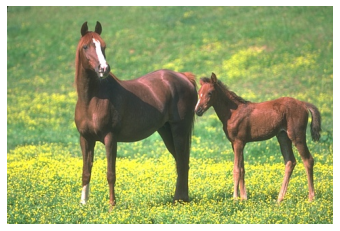

In [4]:
img_path = 'horses.jpg'

# Read image in correct RGB format
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape
print(w, 'x', h)
show_inplace(img)

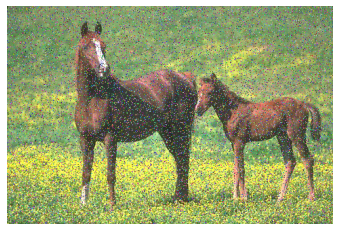

In [5]:
# Optional step to add salt-and-pepper noise to the image
probability = 0.2
for y in range(h):
    for x in range(w):
        if r() <= probability:
            img[y][x][0] = int(r() * 255)
            img[y][x][1] = int(r() * 255)
            img[y][x][2] = int(r() * 255)
show_inplace(img)

Number of superpixels: 74


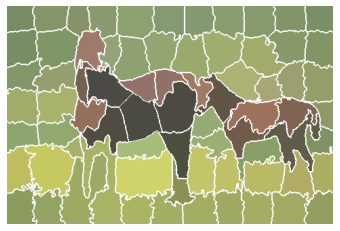

True

In [6]:
# Convert RGB to CIELAB format which is perceptually uniform for small color differences
img = img/255
lab = rgb2lab(img)

# Run Fuzzy SLIC
superpixels = fslic(lab, initial_num_clusters=30, compactness=17, max_iterations=10)
print("Number of superpixels:", len(np.unique(superpixels.reshape((h*w, 3)), axis=0)))

# Convert result back to RGB and display result with contours
result = lab2rgb(superpixels)
unique_labels = np.unique(result.reshape((-1, 3)), axis=0, return_inverse=True)[1].reshape((h, w))
contours = mark_boundaries(result, unique_labels, color=[1,1,1])
show_inplace(contours)
cv2.imwrite('fslic.jpg', cv2.cvtColor((255 * contours).astype(np.uint8), cv2.COLOR_RGB2BGR))

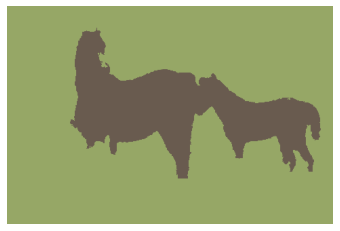

True

In [7]:
clustered = cluster_superpixels(superpixels)
colored = color_regions(clustered, img)
show_inplace(colored)
cv2.imwrite('output.jpg', cv2.cvtColor((255 * colored).astype(np.uint8), cv2.COLOR_RGB2BGR))